In [10]:
import numpy as np
import openml
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from proglearn.forest import UncertaintyForest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [2]:
benchmark_suite = openml.study.get_suite('OpenML-CC18') # obtain the benchmark suite

In [5]:
for i, task_id in enumerate(benchmark_suite.tasks):  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    X, y = task.get_X_and_y()  # get the data
    
    task_name = task.get_dataset().name
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    nominal_indices = task.get_dataset().get_features_by_type('nominal', [task.target_name])
    
    print(i, task_id, task_name, X.shape)

3 kr-vs-kp (3196, 36)
6 letter (20000, 16)
11 balance-scale (625, 4)
12 mfeat-factors (2000, 216)
14 mfeat-fourier (2000, 76)
15 breast-w (699, 9)
16 mfeat-karhunen (2000, 64)
18 mfeat-morphological (2000, 6)
22 mfeat-zernike (2000, 47)
23 cmc (1473, 9)
28 optdigits (5620, 64)
29 credit-approval (690, 15)
31 credit-g (1000, 20)
32 pendigits (10992, 16)
37 diabetes (768, 8)
43 spambase (4601, 57)
45 splice (3190, 60)
49 tic-tac-toe (958, 9)
53 vehicle (846, 18)
219 electricity (45312, 8)
2074 satimage (6430, 36)
2079 eucalyptus (736, 19)
3021 sick (3772, 29)
3022 vowel (990, 12)
3481 isolet (7797, 617)
3549 analcatdata_authorship (841, 70)
3560 analcatdata_dmft (797, 4)
3573 mnist_784 (70000, 784)
3902 pc4 (1458, 37)
3903 pc3 (1563, 37)
3904 jm1 (10885, 21)
3913 kc2 (522, 21)
3917 kc1 (2109, 21)
3918 pc1 (1109, 21)
7592 adult (48842, 14)
9910 Bioresponse (3751, 1776)
9946 wdbc (569, 30)
9952 phoneme (5404, 5)
9957 qsar-biodeg (1055, 41)
9960 wall-robot-navigation (5456, 24)
9964 semeion

In [33]:
task_id = 3022
task = openml.tasks.get_task(task_id)  # download the OpenML task
X, y = task.get_X_and_y()  # get the data

task_name = task.get_dataset().name
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
nominal_indices = task.get_dataset().get_features_by_type('nominal', [task.target_name])

print(task_name)

vowel


In [34]:
n_estimators = 100
n_jobs = 5
cv = 5

clfs = [
#     ('IRF', CalibratedClassifierCV(
#             base_estimator=RandomForestClassifier(n_estimators=n_estimators // cv, n_jobs=n_jobs),
#             method="isotonic",
#             cv=cv,
#         )),
#     ('SigRF', CalibratedClassifierCV(
#             base_estimator=RandomForestClassifier(n_estimators=n_estimators // cv, n_jobs=n_jobs),
#             method="sigmoid",
#             cv=cv,
#         )),
#     ('UF', UncertaintyForest(
#             n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1
#         )),
    ('RF', RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs))
]

In [36]:
cv = 2
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

results_dict = {
    'task': task_name,
    'task_id': task_id,
    'n_samples': n_samples,
    'n_features': n_features,
    'n_classes': n_classes,
    'y': y,
    'test_indices': [],
    'n_estimators': n_estimators,
    'cv': cv,
}

numeric_indices = np.delete(np.arange(X.shape[1]), nominal_indices)
numeric_transformer = SimpleImputer(strategy='median')

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

transformers = []
if len(numeric_indices) > 0:
    transformers += [('numeric', numeric_transformer, numeric_indices)]
if len(nominal_indices) > 0:
    transformers += [('nominal', nominal_transformer, nominal_indices)]
preprocessor = ColumnTransformer(transformers=transformers)

# Store training indices (random state insures consistent across clfs)
for train_index, test_index in skf.split(X, y):
    results_dict['test_indices'].append(test_index)


# X = OneHotEncoder(drop='if_binary', sparse=False).fit_transform(X)

for clf_name, clf in clfs:
    print(clf_name)
    pipeline = Pipeline(steps=[
        ('Preprocessor', preprocessor),
        ('Estimator', clf)])

    fold_probas = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipeline = pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)
        fold_probas.append(y_proba)
    
    results_dict[clf_name] = fold_probas
print('Done')

RF
Done


In [29]:
def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )

In [38]:
score_means = [
    np.mean([
        brier_score_mvloss(
            results_dict['y'][idx], y_proba
        ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
    ]) for name, _ in clfs
]

score_stds = [
    np.std([
        brier_score_mvloss(
            results_dict['y'][idx], y_proba
        ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
    ]) for name, _ in clfs
]

for (name, _), m, s in zip(clfs, score_means, score_stds):
    print(f'{name}: {m:.3f} ({s:.4f})')

RF: 0.023 (0.0001)


In [40]:
score_means = [
    np.mean([
        1 - accuracy_score(
            results_dict['y'][idx], y_proba.argmax(1)
        ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
    ]) for name, _ in clfs
]

score_stds = [
    np.std([
        1 - accuracy_score(
            results_dict['y'][idx], y_proba.argmax(1)
        ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
    ]) for name, _ in clfs
]

for (name, _), m, s in zip(clfs, score_means, score_stds):
    print(f'{name}: {m:.3f} ({s:.4f})')

RF: 0.067 (0.0061)


## Plotting results

In [89]:
from sklearn.metrics import brier_score_loss
from sklearn import preprocessing

In [26]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    print(bin_acc)
    print(bin_conf)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline

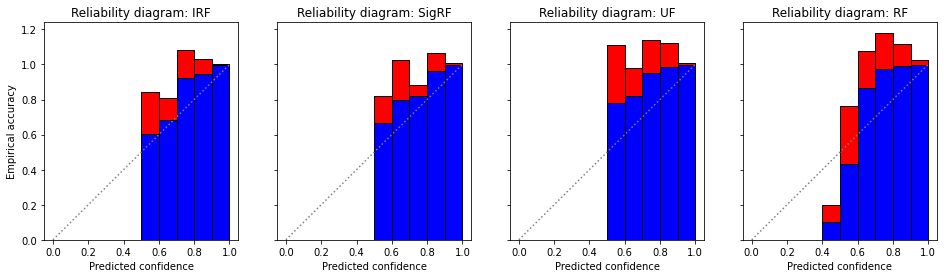

In [328]:
f, axes = plt.subplots(1,4, figsize=(16, 4), sharex=True, sharey=True)
n_bins = 10
bin_centers = np.linspace(0.05, 0.95, 10)
for i, (name, _) in enumerate(clfs):
    accs = []
    confs = []
    mces = []
    for y_proba, test_idx in zip(results_dict[name], results_dict['test_indices']):
        y_true = results_dict['y'][test_idx]
        bin_idx = bin_data(y_proba.max(axis=1), n_bins)
        bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
        accs.append(bin_acc)
        confs.append(bin_conf)
        mces.append(np.abs(bin_acc - bin_conf))
    
    heights = np.mean(accs, axis=0) # mean accuracy in each bin
    axes[i].bar(bin_centers, heights, width=0.1, fc='b', edgecolor='black')
    axes[i].bar(bin_centers, np.mean(mces, axis=0), bottom=heights, width=0.1, fc='r', edgecolor='black')
    axes[i].plot([0, 1], [0, 1], ls=':', c='grey')
    axes[i].set_title(f'Reliability diagram: {name}')
    axes[i].set_xlabel('Predicted confidence')

axes[0].set_ylabel('Empirical accuracy')
# axes[0].set_ylabel('Average confidence')
plt.show()

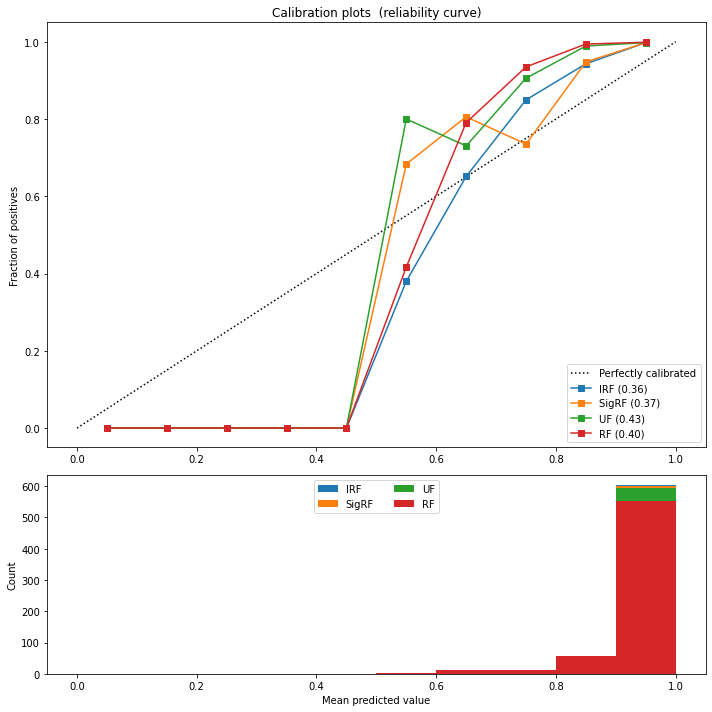

In [371]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, f1_score

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

n_bins = 10
bin_centers = np.linspace(0.05, 0.95, n_bins)

# Initialize network
for name, _ in clfs:
    accs = []
    confs = []
    mces = []
    # briers = []
    
    for y_proba, test_idx in zip(results_dict[name], results_dict['test_indices']):
        y_true = results_dict['y'][test_idx]
        bin_idx = bin_data(y_proba.max(1), n_bins)
        bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
        accs.append(bin_acc)
        confs.append(bin_conf)
        mces.append(np.abs(bin_acc - bin_conf))
        # briers.append(brier_score_mvloss(y_true, y_proba))
        
#     fraction_of_positives, mean_predicted_value = \
#         calibration_curve(y_true, y_proba[:, 1], n_bins=10)

    ax1.plot(bin_centers, np.mean(accs, axis=0), "s-", label=f'{name} ({np.max(mces, axis=1).mean():.2f})')
    # ax1.plot(bin_centers, np.mean(accs, axis=0), "s-", label=f'{name} ({np.mean(briers):.2f})')

    ax2.hist(y_proba.max(1), range=(0, 1), bins=10, label=name)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()